In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
data=yf.download('AAPL',start='2012-01-01',end='2022-01-01')
data.to_csv('AAPL.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.388996,12.427257,12.321814,12.333865,302220800
2012-01-04,12.455576,12.492934,12.330249,12.351940,260022000
2012-01-05,12.593862,12.609527,12.432382,12.501072,271269600
2012-01-06,12.725511,12.736055,12.629708,12.646278,318292800
2012-01-09,12.705327,12.886690,12.693879,12.818905,394024400


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-03 to 2021-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2517 non-null   float64
 1   (High, AAPL)    2517 non-null   float64
 2   (Low, AAPL)     2517 non-null   float64
 3   (Open, AAPL)    2517 non-null   float64
 4   (Volume, AAPL)  2517 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.0 KB


In [5]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,46.522714,46.984073,46.019679,46.495187,2.150847e+08
std,38.735986,39.160685,38.259089,38.698545,1.758602e+08
min,11.939035,12.216318,11.773032,11.860773,4.100000e+07
25%,20.911819,21.066266,20.683240,20.900789,1.031623e+08
50%,29.100609,29.334099,28.844679,29.091626,1.512652e+08
75%,51.483440,52.287726,51.110373,51.671421,2.652272e+08
max,177.423660,179.194667,175.652675,178.200936,1.506120e+09


## Checking Missing Values

In [6]:
data.isnull().sum()

,,0
Price,Ticker,
Close,AAPL,0
High,AAPL,0
Low,AAPL,0
Open,AAPL,0
Volume,AAPL,0


In [7]:
data.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

## Data Visualization

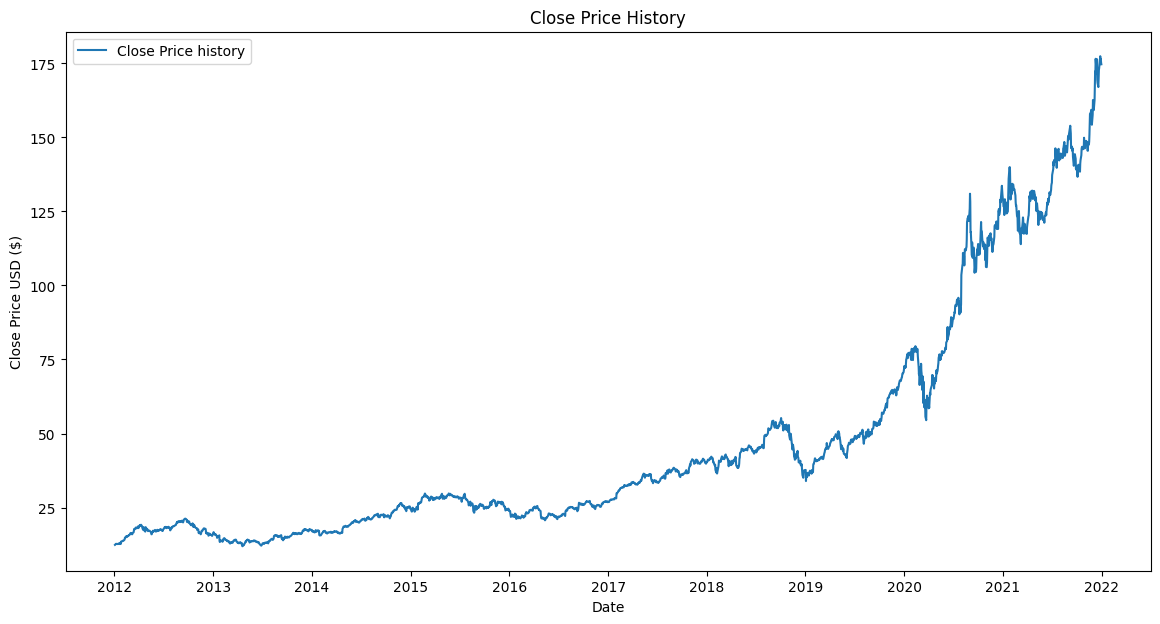

In [8]:
plt.figure(figsize=(14,7))
plt.plot(data.index,data['Close'],label='Close Price history')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Close Price History')
plt.legend()
plt.show()


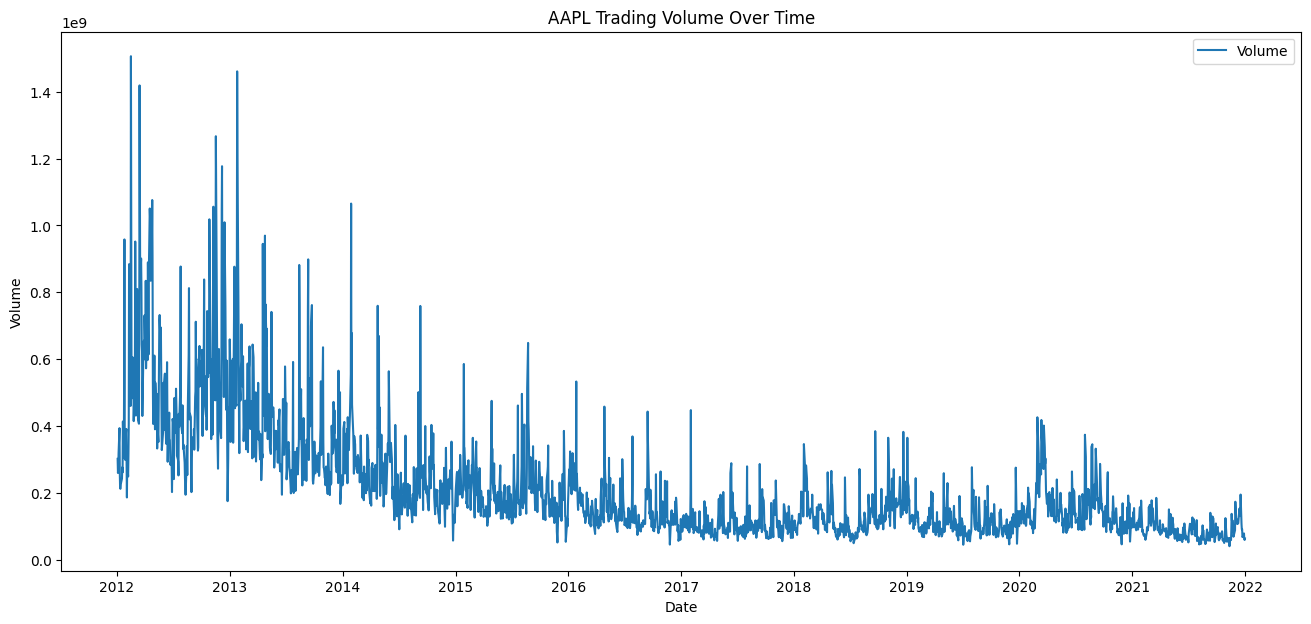

In [9]:
plt.figure(figsize=(16, 7))
plt.plot(data.index, data['Volume'], label='Volume',)
plt.title('AAPL Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

<Axes: title={'center': 'Average Close Price Per Year'}, xlabel='Date'>

<Figure size 1600x700 with 0 Axes>

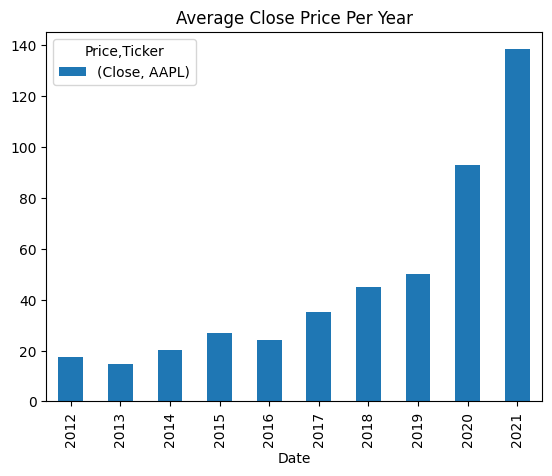

In [10]:
plt.figure(figsize=(16, 7))
data.groupby(data.index.year)['Close'].mean().plot(kind='bar',title='Average Close Price Per Year')


## Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
features= data[['Open', 'High', 'Low','Volume']]

# Apply MinMaxScaler to all features
feature_scaler = StandardScaler()
scaled_data = feature_scaler.fit_transform(features)


target_scaler = StandardScaler()
scaled_close = target_scaler.fit_transform(data[['Close']])

In [72]:
# for api
import joblib
joblib.dump(feature_scaler, "feature_scaler.pkl")
joblib.dump(target_scaler, "target_scaler.pkl")

['target_scaler.pkl']

## Model Building

In [29]:
X, y = [], []
sequence_length = 90

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, :])
    y.append(scaled_close[i, 0])  # Only the 'Close' price

X, y = np.array(X), np.array(y)


In [30]:
split=int(0.8*len(X))
X_train,X_test=X[:split],X[split:]
y_train,y_test=y[:split],y[split:]



In [31]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1941, 90, 4), y_train shape: (1941,)
X_test shape: (486, 90, 4), y_test shape: (486,)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization
from sklearn.metrics import mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber




In [62]:
model=Sequential()

model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.03), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Second LSTM Layer with L2 regularization
model.add(LSTM(units=64, return_sequences=False, kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Early Stopping

In [63]:

from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop when validation loss stops improving
    patience=5,          # Wait for 5 epochs before stopping
    restore_best_weights=True  # Restore best model weights after stopping
)

In [64]:
history=model.fit(X_train,y_train,batch_size=32,epochs=40,validation_data=(X_test,y_test),callbacks=[early_stopping])

Epoch 1/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.1911 - val_loss: 1.6522
Epoch 2/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5479 - val_loss: 0.9324
Epoch 3/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1250 - val_loss: 0.6735
Epoch 4/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0328 - val_loss: 0.4057
Epoch 5/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0150 - val_loss: 0.3498
Epoch 6/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0105 - val_loss: 0.4183
Epoch 7/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0089 - val_loss: 0.0660
Epoch 8/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - val_loss: 0.1149
Epoch 9/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0075 - val_loss: 0.0953
Epoch 10/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0076 - val_loss: 0.0650
Epoch 11/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0073 - val_loss: 0.4399
Epoch 12/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

In [65]:
model.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0485


0.05018641799688339

In [66]:
predictions=model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [67]:
y_pred = model.predict(X_test)

# Reshape before inverse transforming
y_pred = y_pred.reshape(-1, 1)
y_test_actual = y_test.reshape(-1, 1)

# Inverse transform the target variable
y_pred_actual = target_scaler.inverse_transform(y_pred)
y_test_actual = target_scaler.inverse_transform(y_test_actual)




16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [68]:
from sklearn.metrics import mean_absolute_error

In [69]:
mse = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"Mean absolute Error: {mse}")

Mean absolute Error: 6.632261386133516


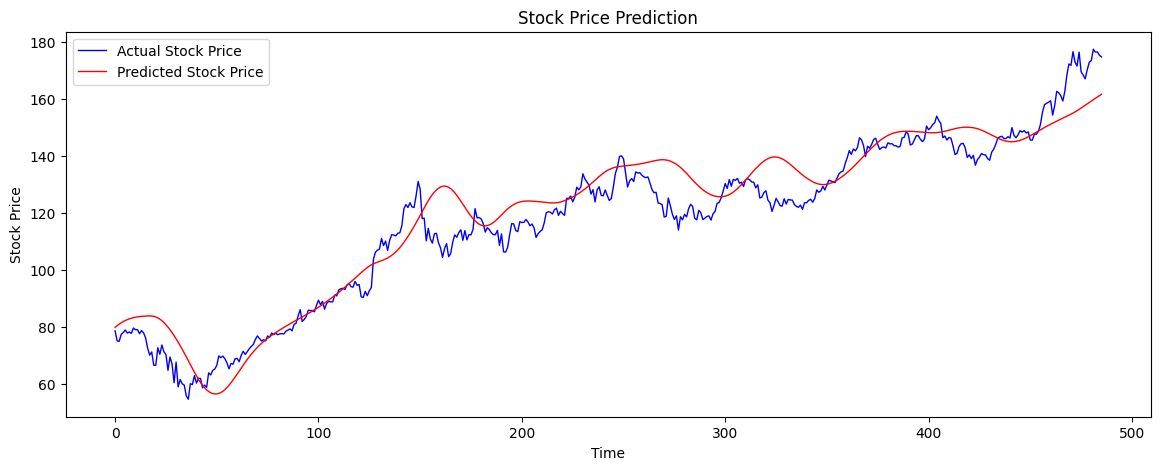

In [70]:

plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price', linewidth=1)
plt.plot(y_pred_actual, color='red', label='Predicted Stock Price',linewidth=1)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [71]:
model.save('stock_price.h5')